In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from random import random as rand


# Portfolio 2 - The Rescorla-Wagner Model

## Intro

In this portfolio, we are going to implement the Rescorla-Wagner model to simulate the behavior of agents interacting with environments that can have different levels of volatility. The Rescorla-Wagner model is a model of classical conditioning in which learning occurs in response to a prediction error. The model itself is a simple algebraic equation describing how associative values between a stimulus and an outcome are updated via error correction. 

This exercise will also introduce you to concepts like *learning rate*, *prediction error*, *volatility*, and *uncertainty* that are central in the reinforcement learning literature and computational psychiatry.

It is recommended that you first explore some resources to get a good intuition of the model before moving to the implementation part. The following videos are good introduction to the core concepts: [video-1](https://www.youtube.com/watch?v=D8b-cflPpec), [video-2](https://www.youtube.com/watch?v=CXrMtA1eNvQ).

**Additional resources**

> [Wikipedia](https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model)

> [Scholarpedia](http://www.scholarpedia.org/article/Rescorla-Wagner_model)

> Sutton, R. & Barto, A. (2018). Reinforcement learning: an introduction. Cambridge, Massachusetts London, England: The MIT Press. *14.2.2. The Rescorla-Wagner Model*.

* [BayesCog Summer 2020 Lecture 09 - Intro to cognitive modeling & Rescorla-Wagner model](https://www.youtube.com/watch?v=tXFKYWx6c3k)
* [BayesCog Summer 2020 Lecture 10 - Implementing Rescorla-Wagner in Stan](https://www.youtube.com/watch?v=M69theIxI3g)

## Learning rate

In this exercise, we will create a simple version of the Rescorla-Wagner model that can update the associative value of a stimulus based on the prediction error of the outcome. We would like to reproduce the figure from [Pulcu & Browning (2019)](https://doi.org/10.1016/j.tics.2019.07.007).

The core idea here is that task volatility (the rapid change of probability outcomes associated with conditioned stimuli) requires an adaptation of the learning rate of a basic (Rescorla-Wagner) reinforcement learning model. You are going to demonstrate that by simulating the performances of 2 agents (high and low learning rate) performing 2 tasks (high and low cat volatility).

Our agent cannot tell beforehand if the cat will scratch him or not, but he can learn from previous experience and update his expectation that he will be scratched in the future. Two key parameters are guiding the value update: the *prediction error* and the *learning rate*.

The *prediction error* is parameterized as:

$$ PE_{t-1} = R_{t-1} - V_{t-1} $$

Updating the value function is defined by:

$$ V_{t} = V_{t-1} + \alpha * PE $$

where $R$ is the outcome, $V$ is the associative strength between the CS and the outcome, and $\alpha$ is the learning rate.

### Exercise

You should create a Python class named `RescorlaWagner`, this class should have 3 core methods: 
* `response()` will generate the agent decision (e.g. stroke the cat or not).
* `update()` will update the outcome (did the cat scratch the agent or not, update the prediction for the next trial).
* `plot()` will plot the result from the entire experiment (hidden probability, responses, and associative value).

All data and relevant parameters should be stored in the class attributes. All methods should be documented following the Matplotlib standard (see [here](https://matplotlib.org/stable/devel/documenting_mpl.html)). You cannot import any additional package (just use Numpy and Matplotlib).

The two cat volatility levels are given by the following vectors:

In [2]:
volatileCat = np.repeat(
    np.array([0.5, 0.8, 0.1, 0.8, 0.1, 0.8, 0.1, 0.8, 0.1, 0.8]),
    10, axis=0)

stableCat = np.repeat(
    np.array([0.5, 0.8, 0.1, 0.8]),
    25, axis=0)

cats = {"Stable":stableCat, "Volatile":volatileCat}

### The model

The interesting thing about this particular scenario is that the US doesn't happen independently of the prediction. In a usual conditioning scenario, US and CS happen independently of the decisions of the subject: here, instead, the presence of scratching can only happen if the agent decides to pet, which depends on their internal beliefs. 

In [3]:
class RescorlaWagner:
  def __init__(self, alpha, start_value, threshold = .5):
    # Learning rate
    self.alpha = alpha
    # Associative strength over time
    self.values = [start_value]
    # Responses over time
    self.responses = []
    self.threshold = threshold

  # The response is threshold-based
  def response(self):
    resp = int(self.values[-1] < self.threshold)
    self.responses.append(resp)
    return resp


  def update(self, outcome):
    # Prediction Error
    PE = outcome - self.values[-1]
    # New value equation
    new_value = self.values[-1] + self.alpha*PE
    self.values.append(new_value)
    
  def plot(self, moods, name):
    plt.figure(figsize=(8,6), dpi=80)
    plt.plot(self.responses, 'bo', label='Responses', alpha = 0.4, color = "#b1b1ff")
    plt.plot(moods, label='True Hidden', linestyle='--', color='black', linewidth=1)
    plt.plot(self.values, label='Internal Expectation', color='#1f77b4', linewidth=1)
    
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plt.title(name)
    plt.xlabel('time')
    plt.ylabel('scratching probability')
    plt.show()

In [4]:
# This class collects methods and variables that make simulations convenient
class Simulation:
  def __init__(self, alpha, cat_type, start_value = .5, threshold = .5):
    self.name = "$\\alpha = $" + str(alpha) + " - " + cat_type
    self.moods = cats[cat_type]
    self.alpha = alpha
    self.start_value = .5
    self.threshold = threshold

  # This is needed for evaluate(), so that the learner can be reset each run
  def init_learner(self):
    return RescorlaWagner(self.alpha, self.start_value, self.threshold)

  # Runs a single simulation on the moods sequence provided
  def run(self, plot = False):
    learner = self.init_learner()  # Initialize learner
    scratches = 0  # Number of scratches received in the run
    pets = 0  # Number of pets performed in the run
    # Run
    for p in self.moods:
      decision = learner.response()
      # Scratch is only received if pet is attempted
      outcome = int(decision and p > rand())
      scratches += outcome
      pets += decision
      # In the case of decision = 0, this acts as a drive to "want" to pet
      learner.update(outcome)
    if plot:
      learner.plot(self.moods, self.name)
    # Evaluation metric to minimize
    # If no pets were given it's the worst performance, therefore 1
    return 1 if pets == 0 else scratches/pets

  # Runs the simulation a number of times and averages the metric
  def evaluate(self, no_runs = 1):
    accumulator = 0
    for _ in range(no_runs):
      accumulator += self.run()
    return round(accumulator/no_runs, 3)

###E1

You should use two agents and make them learn the underlying associations using a high and a low learning rate (e.g 0.2 vs 0.8). You should have four plots in total (learning rate * task variability).

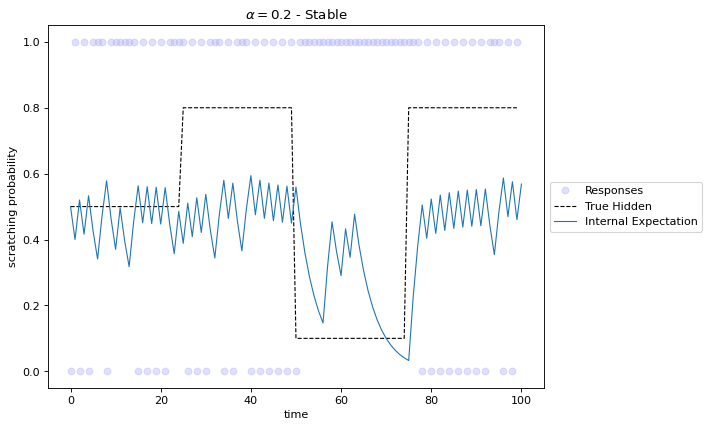

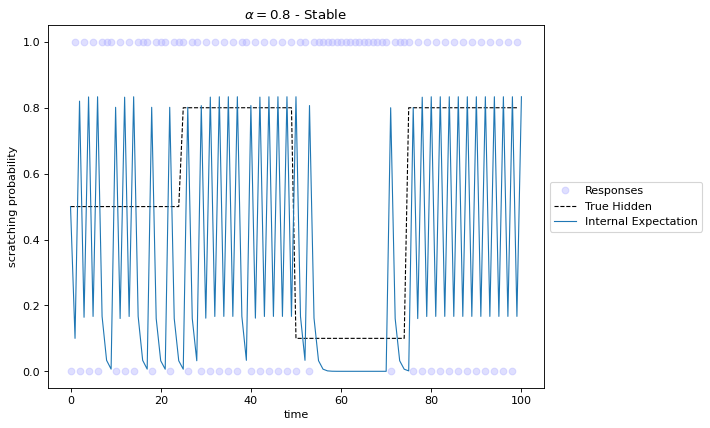

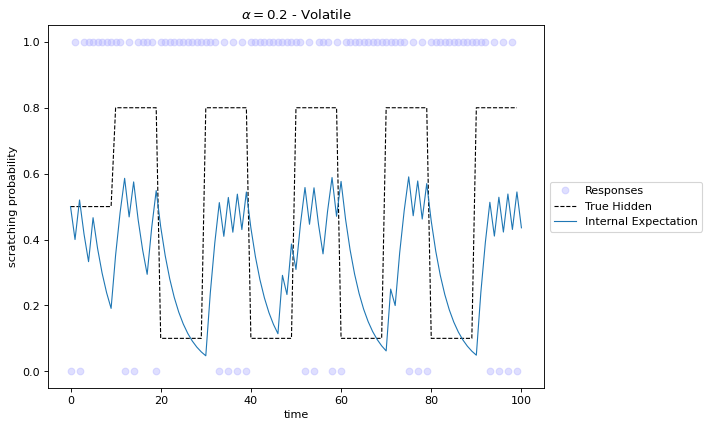

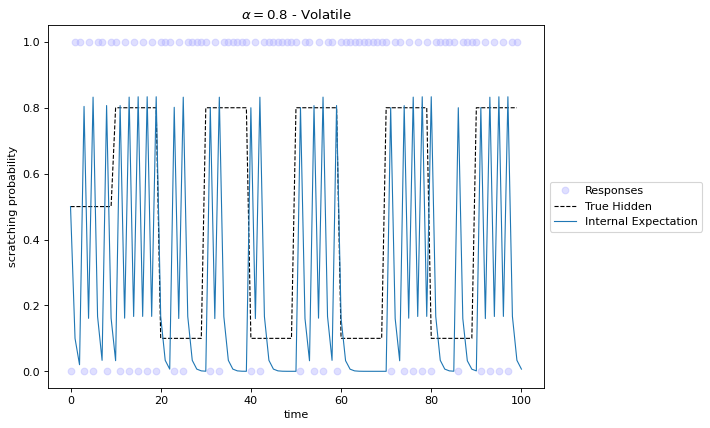

In [5]:
cat_labels = ["Stable", "Volatile"]
alphas = [.2, .8]

for cat in cat_labels:
  for alpha in alphas:
    Simulation(alpha, cat).run(True)

###E2

How can we find an optimal learning rate that would maximize the outcome (stroke the cat without being scratched most of the time)? Run 1000 simulations and use a robust estimate.

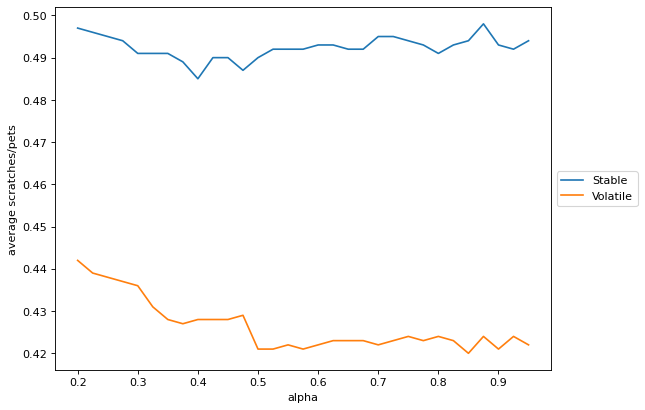

Best Stable: alpha = 0.4 with metric 0.485
Best Volatile: alpha = 0.85 with metric 0.42


In [6]:
alphas = np.linspace(0.2,.95,31)
repeat_no = 1000

outcomes = {}

plt.figure(figsize=(8,6), dpi=80)
for cat in cat_labels:
  outcomes[cat] = []
  for alpha in alphas:
    outcomes[cat].append(Simulation(alpha, cat).evaluate(repeat_no))
  plt.plot(alphas, outcomes[cat], label = cat)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.xlabel('alpha')
plt.ylabel('average scratches/pets')
    
plt.show()

min_o = {cat:min(outcomes[cat]) for cat in cat_labels}
best = {cat:round(alphas[outcomes[cat].index(min_o[cat])],2) for 
        cat in cat_labels}
for cat in cat_labels:
  print("Best "+cat+": alpha = " + str(best[cat]) + 
        " with metric " + str(min_o[cat]))

## Blocking

We have built from the previous exercise an agent that can update its expectation about future outcomes associated with a stimulus. However, one of the main strengths of the Rescorla-Wagner model, and the reason why it is still used as a baseline reference for a reinforcement learning task, is that it can explain results that occur under more complex setups like blocking.

Blocking happens when many CSs are presented in association with an outcome, but only some of them show a conditioning response. In the previous example, we used only one CS (the cat) that was always presented, and the outcome probability was varying through time. Here, we are going to present 2 stimuli ($A$ and $X$).

$V_{A}$, $V_{X}$ and $V_{AX}$ denote the associative strength of stimuli $A$, $X$ and the compound $AX$. Suppose that on a trial the compound $CS_{AX}$ is followed by a $US$ laballed stimulus $Y$. Then the associative strengths of the stimulus components change according to these expression:

$$ \Delta V_{A} = \alpha_{A}\beta_{Y}(R_{Y}-V_{AX})$$
$$ \Delta V_{X} = \alpha_{X}\beta_{Y}(R_{Y}-V_{AX})$$

Here, $V_{AX} = V_{A} + V_{X}$. $\alpha$ refers to the $CS$ salience and $\beta$ refers to the $US$ salience, which can be 0 or 1 given the array below. $\alpha_{a}$ is encoded in `stimulusA`, $\alpha_{x}$ is encoded in `stimulusX` and $\beta_{Y}$ is encoded on `unconditioned`. $R_{Y}$ is the asymptotic level of associative strength that the US $Y$ can support. In this case, this will be set to 1. Note that we are not explicitely describing the learning rate here, but this can be added by scaling $\Delta V_{A}$ and $\Delta V_{X}$ by some number between 0 and 1.

In [7]:
unconditioned = np.repeat(
    np.array([0.0, 1.0, 0.0, 1.0, 0.0, 0.0]),
    10, axis=0)

stimulusA = np.repeat(
    np.array([0.0, 1.0, 0.0, 1.0, 0.0, 0.0]),
    10, axis=0)

stimulusX = np.repeat(
    np.array([0.0, 0.0, 0.0, 1.0, 0.0, 1.0]),
    10, axis=0)

## Exercise

* Using the previous `RescorlaWagner` class, make some modifications that will let it use a compound of CS variables (here $A$ and $X$) to predict the unconditioned stimulus. Because the association $A-Y$ is learned first, we should observe a *blocking* of $X-Y$ when it is later presented.

* Create a figure synthesizing the main result from this task, demonstrating that the Rescorla-Wagner model can explain the blocking effect. Ideally, the figure should have 5 rows:
* Unconditioned stimulus $Y$
* Stimulus $A$
* Stimulus $X$
* $V_{A}$
* $V_{X}$

In [8]:
class MultiStimulusRW:
  def __init__(self, alpha, start_values):
    # Learning rate
    self.alpha = alpha
    # Associative strength over time
    self.values = { key:[start_values[key]] for key in start_values.keys() }
    
  # The model is not an agent: it only predicts the environment
  def prediction(self, stimuli):
    pred = 0
    for lab in stimuli.keys():
      pred += stimuli[lab]*self.values[lab][-1]
    return pred

  # Implementation of the update equations
  def update(self, outcome, stimuli):
    # Constant part
    delta_raw = outcome*(1 - self.prediction(stimuli))*self.alpha
    # Variable-dependent part
    for lab in self.values:
      new_val = stimuli[lab]*delta_raw + self.values[lab][-1]
      self.values[lab].append(new_val)

  def plot(self, outcomes, stimuli):
    _, plts = plt.subplots(2,1, figsize=(8,6), gridspec_kw={'height_ratios':[3,1]})
    out_plt = outcomes.copy()
    out_plt[out_plt==0] = np.nan
    plts[1].plot(out_plt, label = "Y", linewidth=5)
    scale = .8
    for lab in stimuli.keys():
      stim_plot = stimuli[lab].copy()
      stim_plot[stim_plot==0] = np.nan
      plts[1].plot(scale*stim_plot, label = lab, linewidth=5)
      plts[0].plot(self.values[lab], label = "$V_"+lab+"$")
      # The stimuli are scaled for better visualization.
      # Scaling does not affect the strength of the stimuli
      scale -= .2
    
    plts[0].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plts[1].legend(loc='center left',bbox_to_anchor=(1, 0.5))
    plts[0].set_xlabel('time')
    plts[0].set_ylabel('associative strength')
    plts[1].set_ylabel('stimuli')
    plts[1].set_xlim(xmin=0)
    plts[1].axes.yaxis.set_ticklabels([])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.20, wspace=0.4)
    plt.show()

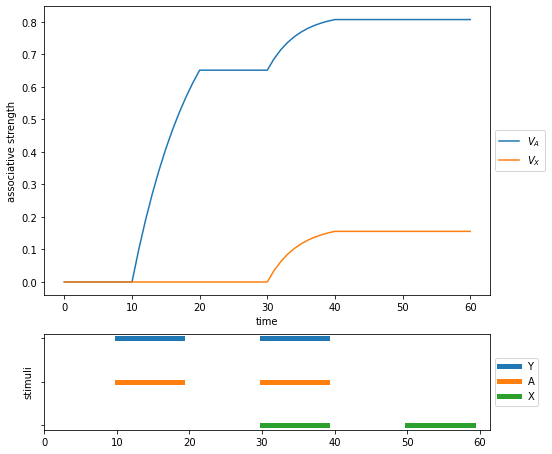

In [9]:
RW = MultiStimulusRW(.1, {"A":0, "X":0})

for y, a, x in zip(unconditioned, stimulusA, stimulusX):
  stims = {"A":a, "X":x}
  RW.update(y, stims)

RW.plot(unconditioned, {"A":stimulusA, "X":stimulusX})